## Pose model evaluation

This notebook uses the MARSeval module from https://github.com/neuroethology/MARS_pycocotools to evaluate a trained pose model in terms of a few commonly used computer vision metrics, including the **Object Keypoint Similarity** (OKS) and **Percent Correct Keypoints** (PCK).

In [ ]:
%matplotlib inline

import evaluation
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Evaluating model performance on the test set

Before we can quantify performance, we have to run our trained model on the held-out test set. We do this using:
#### `evaluation.run_test`

#### Input
* `project_path` the path to your MARS project

#### Output
* `pose_performance.json` ground truth and predicted keypoint locations for all of the images in your test set; saved inside `my_project/pose/<model name>_evaluation`.

In the next section, we'll use some additional scripts to unpack and visualize the contents of this json.

In [ ]:
import evaluation

project_path = 'D:\my_project'
evaluation.run_test(project_path)

## Quantifying model performance

Now that we've run the model on our test set, we'll use a couple metrics to evaluate how well it's doing. These metrics make use of the [`MARSeval`](https://github.com/neuroethology/MARS_pycocotools) module, which is based on the popular [CoCo API](https://github.com/cocodataset/cocoapi) for evaluation of computer vision models.

### Creating the evaluation objects
Before computing our various metrics, we are going to create a `cocoEval` object that stores a distilled version of our model performance. We'll do this by calling:

#### `evaluation.coco_eval`

#### Input
* Path to your MARS project.


#### Optional argument: choice of $\sigma$
One of the metrics we will apply, the Object Keypoint Similarity (defined below), uses a scaling term $\sigma$ to normalize measures of model error.

Calling `evaluation.coco_eval(fid, fixedSigma='narrow')` computes OKS using a fixed value of $\sigma$ for all keypoints: available values are `narrow` ($\sigma = 0.025$), `moderate` ($\sigma = 0.05$), `wide` ($\sigma = 0.1$), and `ultrawide` ($\sigma = 0.15$).

If you don't pass any arguments, `fixedSigma='narrow` is the default.

If you use the same keypoint names as MARS, you can instead evaluate performance using MARSeval's estimates of human annotator variability ($\sigma$) for all keypoints in the MARS dataset (nose tip, right/left ear, neck, right/left side body, and tail base), calculated from the original 15,000-frame MARS pose dataset. To do so, call `evaluation.coco_eval(fid,view=top)` or `evaluation.coco_eval(fid,view=front)`, to use top- or front-view sigmas, respectively.


#### Output
* `performance` is a dictionary with keys for each pose model, each of which contains a dictionary of `cocoEval` objects- one for each body part, and one pooling across all parts. We can use these objects to get some performance metrics for our model.

In [6]:
project_path = 'D:/my_project'
performance = evaluation.coco_eval(project_path)

### Object-keypoint similarity

First, we'll look at the object-keypoint similarity (OKS) of our model's pose estimates. The OKS is a measure of pose accuracy that normalizes performance by the estimated variance of human annotators:
![OKS summary](https://github.com/neuroethology/MARS_pycocotools/raw/master/docs/keypoint_similarity.png)

In the human pose estimation literature, OKS values are typically summarized in terms of the Mean average precision (mAP) and Mean average recall (mAR). To understand these terms, we must first talk about confidence, precision, and recall.

In machine learning, **Precision** is computed as **True Positives / (True Positives + False Positives)**, while **Recall** is **True Positives / True Positives + False Negatives**. For pose estimation, a True Positive is clear: it's when a keypoint is detected falls within some "permissible radius" $R$ of the ground truth. But what makes a False Positive vs a False Negative?

MARS keypoint predictions have a **location** $(x,y)$ as well as a **confidence** $s$- the latter reflects the model's certainty that a keypoint is indeed detected at the provided location. (MARS's pose model will return keypoint locations regardless of confidence, however low confidence is often a good indicator that those locations will be bad.) We will therefore call a keypoint a False Positive if confidence is above some threshold $C$ but location is far from ground truth, and a False Negative otherwise. Because there is always a ground truth keypoint location (even when occluded), there is no True Negative category.

Given fixed permissible radius $R$, we can therefore plot Precision-Recall curves as one would for a classifier: by plotting Precision vs Recall as we gradually lower the confidence threshold $C$. We summarize this plot by taking the approximate area under the P-R curve, a value called the **Average Precision** (AP). Alternatively, we can report the fraction of True Positive detections if any confidence score is accepted- this is called the **Average Recall** (AR).

The last piece in the puzzle is our choice of permissible radius $R$: how close does a predicted keypoint have to be to ground truth to count as correct? And with what units? For units, we will use our previously defined OKS, which ranges from 0 (poor) to 1 (perfect). As for choice of $R$, the accepted approach in machine learning is to simply recompute the AP and AR for a range of values of $R$-- specifically, $R = \{0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95\}$, and then to take the mean value of AP and AR across these 10 values: hence, the **mean Average Precision** and **mean Average Recall**.

All that said: this metric is quick to generate- our `cocoEval` objects inside `performance` have a built-in method to output OKS mAP and mAR values to terminal:

#### `performance[part].summarize()`

#### Input
* `part` is the part we want performance for- either "all" or the name of a specific body part.

#### Output

* **Mean average precision (mAP)** computed for all keypoints in the category `part.
* **Mean average recall (mAR)** computed for all keypoints in the category `part.

In [9]:
for model in performance.keys():
    for part in performance[model].keys():
        print('Performance for keypoint: ' + part + ' ---' if part!='all' else 'Mean performance across keypoints ---')
        performance[model][part].summarize()
        print('')

Mean performance across keypoints ---
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.637
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.675

Performance for keypoint: nose ---
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.695
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.750

Performance for keypoint: right ear ---
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.731
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.784

Performance for keypoint: left ear ---
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.710
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.776

Performance for keypoint: top of neck ---
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.666
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.742

P

### OKS histograms

It can also be useful to look at a histogram of OKS values across all images in the test set. We can produce one using: 

#### `evaluation.compute_oks_histogram`

#### Inputs
* One of the `cocoEval` objects stored in `performance`.

#### Outputs
* `counts` and `bins` for a histogram of OKS values.

Text(0.5, 0, 'OKS')

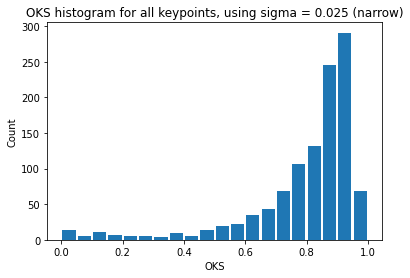

In [13]:
model = 'top'  # the pose model we're evaluating
usePart = 'all'  # the part we're going to look at (or use 'all' to look at mean across body parts)

# compute counts for histogram of OKS values.
counts, bins = evaluation.compute_oks_histogram(performance[model][usePart])

# and take a look:
binSize = 0.9/len(bins)
plt.bar((bins[1:]+bins[:-1])/2, counts, binSize);
plt.title('OKS histogram for ' + ('all keypoints' if usePart == 'all' else usePart) + ', using sigma = 0.025 (narrow)')
plt.ylabel('Count')
plt.xlabel('OKS')

### Choice of $\sigma$, revisited

Now that you know what $\sigma$ is, let's repeat the analysis above with the $\sigma$ values derived from the MARS dataset, and look at our two histograms of OKS values side-by-side to see the difference.

In [18]:
performance_MARS = evaluation.coco_eval(project_path,view='top')

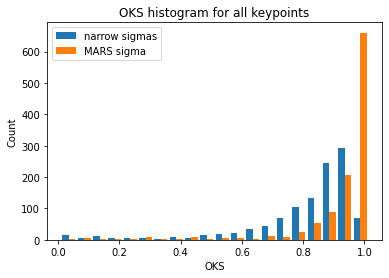

In [21]:
model = 'top'  # the pose model we're evaluating
usePart = 'all'

counts_MARS, _ = evaluation.compute_oks_histogram(performance_MARS[model][usePart])

binSize = 0.45/len(bins)
plt.bar((bins[1:]+bins[:-1])/2, counts, binSize)
plt.bar((bins[1:]+bins[:-1])/2+binSize, counts_MARS, binSize)
plt.title('OKS histogram for ' + ('all keypoints' if usePart == 'all' else usePart))
plt.ylabel('Count')
plt.xlabel('OKS')
plt.legend(('narrow sigmas', 'MARS sigma'));

### Percent Correct Keypoints (PCK)

We can also evaluate our pose model in terms of the percent of time estimated keypoints fall within a radius $X$ of ground truth, for a range values of $X$. This is called the Percent Correct Keypoints (PCK). To calculate PCK, we will use:

#### `evaluation.plot_model_PCK`:

#### Inputs
* Path to your MARS project

#### Outputs
Plotted cdfs of PCK values for human annotators and for your trained MARS model.

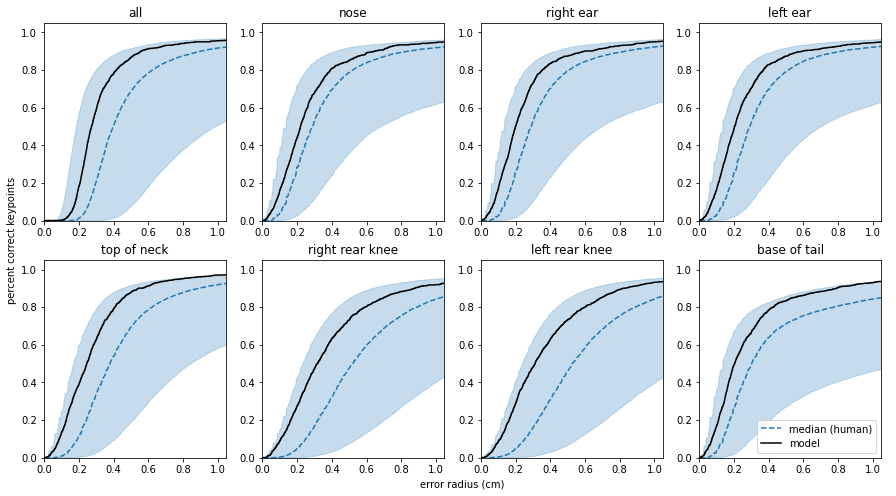

In [25]:
from hourglass_pose import evaluation

project_path = 'D:\my_project'
evaluation.plot_model_PCK(project_path, combine_animals=True)